In [ ]:
!wget https://raw.githubusercontent.com/teavanist/MNIST-JPG/master/MNIST%20Dataset%20JPG%20format.zip

--2023-11-26 13:22:10--  https://raw.githubusercontent.com/teavanist/MNIST-JPG/master/MNIST%20Dataset%20JPG%20format.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 52766564 (50M) [application/zip]
Saving to: ‘MNIST Dataset JPG format.zip’

MNIST Dataset JPG f 100%[===================>]  50.32M  --.-KB/s    in 0.1s    

2023-11-26 13:22:10 (342 MB/s) - ‘MNIST Dataset JPG format.zip’ saved [52766564/52766564]



In [ ]:
!pip install lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.9/776.9 kB 22.5 MB/s eta 0:00:00


In [ ]:
!unzip 'MNIST Dataset JPG format.zip'

Streaming output truncated to the last 5000 lines.
 extracting: MNIST Dataset JPG format/MNIST - JPG - training/9/18241.jpg  
 extracting: MNIST Dataset JPG format/MNIST - JPG - training/9/18251.jpg  
 extracting: MNIST Dataset JPG format/MNIST - JPG - training/9/1826.jpg  
 extracting: MNIST Dataset JPG format/MNIST - JPG - training/9/18277.jpg  
 extracting: MNIST Dataset JPG format/MNIST - JPG - training/9/18296.jpg  
 extracting: MNIST Dataset JPG format/MNIST - JPG - training/9/183.jpg  
 extracting: MNIST Dataset JPG format/MNIST - JPG - training/9/18350.jpg  
 extracting: MNIST Dataset JPG format/MNIST - JPG - training/9/18355.jpg  
 extracting: MNIST Dataset JPG format/MNIST - JPG - training/9/18374.jpg  
 extracting: MNIST Dataset JPG format/MNIST - JPG - training/9/18377.jpg  
 extracting: MNIST Dataset JPG format/MNIST - JPG - training/9/18382.jpg  
 extracting: MNIST Dataset JPG format/MNIST - JPG - training/9/18387.jpg  
 extracting: MNIST Dataset JPG format/MNIST - JPG - 

In [ ]:
from glob import glob
import pandas as pd
import numpy as np
import os
import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping
import torchmetrics
import torch
from torch import nn
import torchvision
from torchvision import transforms
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random
import gc
from lightning.pytorch.callbacks import ModelSummary
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Set stable random
def set_seed(seed: int = 0) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHEED"] = str(seed)
    print(f"Random seed set as {seed}")

set_seed()


Random seed set as 0


In [ ]:
# Set paths
val_path = '/content/MNIST Dataset JPG format/MNIST - JPG - testing'
train_path = "/content/MNIST Dataset JPG format/MNIST - JPG - training"
list_ = [name for name in os.listdir(train_path)]

In [ ]:
# Function get path
def get_path(path):
    paths = []
    for name in list_:
        l = glob(f"{path}/{name}/*.jpg")
        for i in l:
            paths.append(
                {
                    "name":name,
                    "path": i,
                    "label": int(name)
                }
            )
    return paths

train_paths = get_path(train_path)
val_paths = get_path(val_path)

In [ ]:
# Get 40% size dataset for training
_, train_paths = train_test_split(train_paths, test_size=0.4, random_state=43)
_, val_paths = train_test_split(val_paths, test_size=0.4, random_state=43)

In [ ]:
class DataSet(torch.utils.data.Dataset):

    def __init__(self, features, transform=None):
        super(DataSet, self).__init__()
        self.features = features
        self.transform = transform

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        paths = self.features[idx]["path"]
        images = torchvision.io.read_image(paths)
        images = torch.stack([images[0], images[0], images[0]], 0)

        if self.transform is not None:
            images = self.transform(images)

        label = torch.tensor(self.features[idx]["label"])
        return {"images": images, "labels": label}

Data = DataSet(train_paths)

In [ ]:
next(iter(Data))['images'].shape

torch.Size([3, 28, 28])

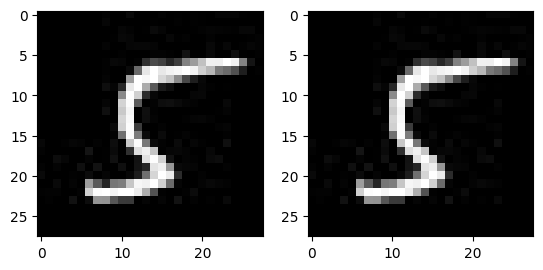

In [ ]:
# Show image of dataset
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]

    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))

show([next(iter(Data))['images'], next(iter(Data))['images']])

In [ ]:

class DataModule(L.LightningDataModule):

    def __init__(self, batch_size, num_workers, train_path, val_path):
        super(DataModule, self).__init__()
        self.train_path = train_path
        self.val_path = val_path
        self.batch_size = batch_size
        self.num_workers = num_workers
        # Create list of transformation in compose

        # Create compose
        self.train_transforms = transforms.Compose(
            [
                transforms.ToPILImage(),
                transforms.Resize((224, 224)),
                transforms.RandomHorizontalFlip(),
                transforms.ColorJitter(
                    brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1
                ),
                transforms.ToTensor(),
                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
            ]
        )

        self.test_transforms = transforms.Compose(
            [
                transforms.ToPILImage(),
                transforms.Resize((224, 224)),
                transforms.RandomHorizontalFlip(),
                transforms.ColorJitter(
                    brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1
                ),
                transforms.ToTensor(),
                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
            ]
        )

    def setup(self, stage=None):
        train_paths = get_path(self.train_path)
        val_paths = get_path(self.val_path)
        train_paths, test_paths = train_test_split(train_paths, test_size=0.2, random_state=0)

        self.train_dataset = DataSet(
            train_paths, transform=self.train_transforms   # Applying data_transforms in DataSet
        )
        self.val_dataset = DataSet(
            val_paths, transform=self.test_transforms
        )
        self.test_dataset = DataSet(
            test_paths, transform=self.test_transforms
        )

    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.train_dataset, shuffle=True,
                                          batch_size=self.batch_size, num_workers=self.num_workers)

    def val_dataloader(self):
        return torch.utils.data.DataLoader(self.val_dataset, shuffle=False,
                                          batch_size=self.batch_size, num_workers=self.num_workers)

    def test_dataloader(self):
        return torch.utils.data.DataLoader(self.test_dataset, shuffle=False,
                                          batch_size=self.batch_size, num_workers=self.num_workers)

data_module = DataModule(
    batch_size=8, num_workers=4,
    train_path = train_path, val_path = val_path)
data_module.setup()
train_loader = data_module.train_dataloader()
val_loader = data_module.val_dataloader()

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
next(iter(train_loader))['images'].shape

torch.Size([8, 3, 224, 224])

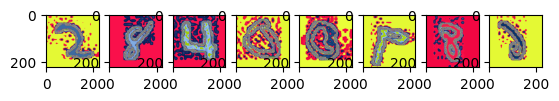

In [ ]:
images = [image for image in next(iter(train_loader))['images']]
show(images)

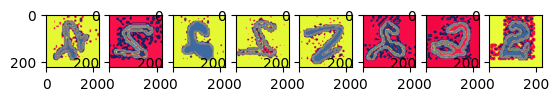

In [ ]:
images = [image for image in next(iter(val_loader))["images"]]
show(images)

In [ ]:
# Define a LightningModule using VGG16 from library
class VGG16(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG16, self).__init__()
        self.features = self._make_layers()
        self.classifer = nn.Sequential(

            # First Linear
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),

            # Second Linear
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),

            # Last Layer for classification
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifer(x)
        return x

    def _make_layers(self):
        layers = []
        in_channels = 3
        vgg_config = [64,       64, 'M',
                     128,      128, 'M',
                     256, 256, 256, 'M',
                     512, 512, 512, 'M',
                     512, 512, 512, 'M']

        for v in vgg_config:
            if v == 'M':
                layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            else:
                conv2d = nn.Conv2d(
                    in_channels = in_channels,
                    out_channels = v,
                    kernel_size = 3,
                    padding = 1
                )
                layers += [conv2d, nn.ReLU(inplace=True)]
                in_channels = v

        return nn.Sequential(*layers)


# Define a LightningModule using the custom VGG16
class CustomVGG16(L.LightningModule):
    def __init__(self, num_classes=10, lr=1e-4, model = VGG16):
        super(CustomVGG16, self).__init__()
        self.model = model(num_classes)
        self.lr = lr
        self.loss = torch.nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch['images'], batch['labels']
        y_hat = self(x)
        loss = self.loss(y_hat, y)
        accuracy = (y_hat.argmax(dim=1) == y).float().mean()
        self.log_dict({'loss': loss, 'acc': accuracy}, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch['images'], batch['labels']
        y_hat = self(x)
        val_loss = self.loss(y_hat, y)
        val_accuracy = (y_hat.argmax(dim=1) == y).float().mean()
        self.log_dict({'val_loss': val_loss, 'val_acc': val_accuracy}, prog_bar=True)
        return val_loss

    def test_step(self, batch, batch_idx):
        x, y = batch['images'], batch['labels']
        y_hat = self(x)
        test_loss = self.loss(y_hat, y)
        test_accuracy = (y_hat.argmax(dim=1) == y).float().mean()
        self.log_dict({'test_loss': test_loss, 'test_acc': test_accuracy}, prog_bar=True)
        return test_loss

    def predict_step(self, batch, batch_idx, dataloader_idx=None):
        x, _ = batch['images'], batch['labels']
        y_hat = self(x)
        probabilities = torch.softmax(y_hat, dim=1)
#         predicted_labels = torch.argmax(probabilities, dim=1)
        predicted_labels = torch.max(probabilities, dim=1)
#         return {"y_pred": predicted_labels, 'y_prob': torch.max(probabilities, dim=1)}
        return {'y_pred': predicted_labels[1], 'y_prob': predicted_labels[0]}

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer


In [ ]:
# Saving model params
model_checkpoint = ModelCheckpoint(
    dirpath = 'checkpoint/',
    monitor = 'val_acc',
    verbose = True,
    mode = 'max',
    save_top_k = 1
)

# Early stopping callbacks
early_stopping = EarlyStopping(
    monitor = 'val_acc', mode = 'max',
    min_delta = 1e-4, patience = 5
)

callbacks = [model_checkpoint, early_stopping, ModelSummary(max_depth=1)]

model_build = VGG16
model = CustomVGG16(model = model_build)

data_module = DataModule(
    batch_size = 128, num_workers = 4,
    train_path = train_path, val_path = val_path
)
trainer = L.Trainer(
    max_epochs = 2,
    detect_anomaly = True,
    devices="auto",
    callbacks = callbacks
)

trainer.fit(model, data_module)

INFO: Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:lightning.pytorch.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO: You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
INFO:lightning.pytorch.utilities.rank_zero:You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
IN

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 375: 'val_acc' reached 0.97070 (best 0.97070), saving model to '/content/checkpoint/epoch=0-step=375.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 375: 'val_acc' reached 0.97070 (best 0.97070), saving model to '/content/checkpoint/epoch=0-step=375.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 1, global step 750: 'val_acc' reached 0.98410 (best 0.98410), saving model to '/content/checkpoint/epoch=1-step=750.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 750: 'val_acc' reached 0.98410 (best 0.98410), saving model to '/content/checkpoint/epoch=1-step=750.ckpt' as top 1
INFO: `Trainer.fit` stopped: `max_epochs=2` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


In [ ]:
# Testing in training set
trainer.test(model, data_module)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9798333048820496     │
│         test_loss         │    0.06111101433634758    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.06111101433634758, 'test_acc': 0.9798333048820496}]

In [ ]:
# Data for testing
data_module = DataModule(
    batch_size = 64, num_workers = 2, train_path = train_path, val_path = val_path
)
data_module.setup()
#train_loader = data_module.train_dataloader()
test_loader = data_module.test_dataloader()

In [ ]:
model = CustomVGG16.load_from_checkpoint("/content/checkpoint/epoch=1-step=750.ckpt")
predictions_ = trainer.predict(model, test_loader)
all_max_indices = torch.tensor([])
all_prob = torch.tensor([])
for i in predictions_:
    all_max_indices = torch.concat([all_max_indices,i['y_pred']])
    all_prob = torch.concat([all_prob,i['y_prob']])

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [ ]:
all_max_indices, all_prob

(tensor([2., 4., 7.,  ..., 8., 4., 4.]),
 tensor([0.9953, 1.0000, 0.9995,  ..., 1.0000, 1.0000, 0.8599]))

Visulalize prediction

In [ ]:
def plot_image(i, imgs, pred_labels, probs):
    true_label, img, pred_label, prob = imgs[i]['labels'], imgs[i]['images'], pred_labels[i], probs[i]

    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    img = img.permute(1, 2, 0)
    plt.imshow(img, cmap=plt.cm.binary)

    color = ('green' if pred_label == true_label else 'red')
    plt.xlabel("Predict: {} {:2.0f}% (True: {})".format(pred_label,100*prob, true_label), color=color)


Show images prediction


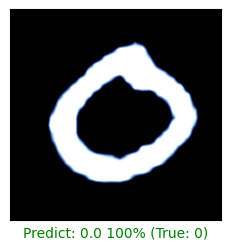

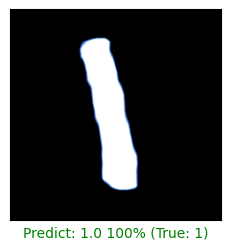

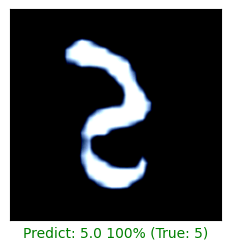

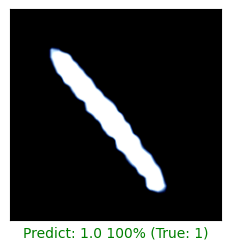

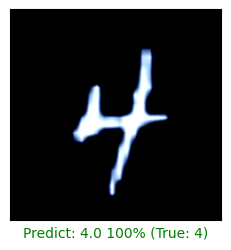

In [ ]:
lst = np.random.randint(0, len(all_prob), 5)
print('Show images prediction')
for i in lst:
  plt.figure(figsize=(6,3))
  plt.subplot(1,2,1)
  plot_image(i, test_loader.dataset, all_max_indices, all_prob)
  plt.show()


CLASSIFICATION REPORT 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      1218
           1       0.99      0.99      0.99      1369
           2       0.96      0.98      0.97      1178
           3       0.98      0.99      0.98      1267
           4       0.99      0.98      0.98      1167
           5       0.99      0.94      0.97      1090
           6       0.98      0.99      0.98      1171
           7       0.98      0.99      0.99      1277
           8       0.99      0.98      0.98      1092
           9       0.96      0.98      0.97      1171

    accuracy                           0.98     12000
   macro avg       0.98      0.98      0.98     12000
weighted avg       0.98      0.98      0.98     12000

--------------------------------------------------
CONFUSION MATRIX 



<Axes: >

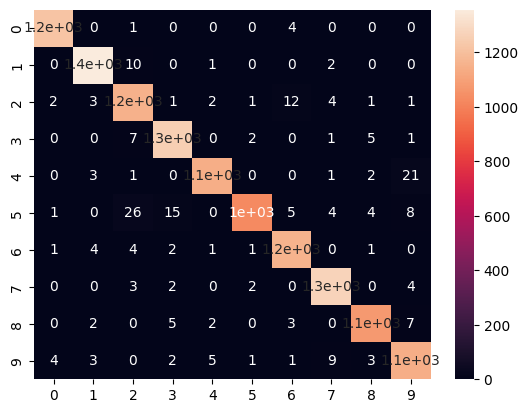

In [ ]:
y_true = np.array([data['labels'] for data in iter(test_loader.dataset)])
y_pred = all_max_indices

print('CLASSIFICATION REPORT \n',classification_report(y_true, y_pred))
print(f'-'*50)
cm = confusion_matrix(y_true, y_pred)
print('CONFUSION MATRIX \n')
sns.heatmap(cm, annot=True)

# Exercises

## 1. Training with full dataset

In [ ]:
# Empty cache in GPU
# def clear_gpu_memory():
#     torch.cuda.empty_cache()
#     gc.collect()
#     del variables

torch.cuda.empty_cache()

In [ ]:
# Set paths
val_path = '/content/MNIST Dataset JPG format/MNIST - JPG - testing'
train_path = "/content/MNIST Dataset JPG format/MNIST - JPG - training"
list_ = [name for name in os.listdir(train_path)]

# Get data
train_paths = get_path(train_path)
val_paths = get_path(val_path)

# Get data module
data_module = DataModule(
    batch_size=128, num_workers=4,
    train_path = train_path, val_path = val_path)
data_module.setup()
train_loader = data_module.train_dataloader()
val_loader = data_module.val_dataloader()

# Saving model params
model_checkpoint = ModelCheckpoint(
    dirpath = 'checkpoint/full_dataset',
    monitor = 'val_acc',
    verbose = True,
    mode = 'max',
    save_top_k = 1
)

# Early stopping callbacks
early_stopping = EarlyStopping(
    monitor = 'val_acc', mode = 'max',
    min_delta = 1e-4, patience = 5
)

callbacks = [model_checkpoint, early_stopping, ModelSummary(max_depth=1)]

model1 = CustomVGG16.load_from_checkpoint("/content/checkpoint/epoch=1-step=750.ckpt")


trainer1 = L.Trainer(
    max_epochs = 2,
    detect_anomaly = True,
    devices="auto",
    callbacks = callbacks
)

trainer1.fit(model1, data_module)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
INFO: Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:lightning.pytorch.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO: You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommende

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 375: 'val_acc' reached 0.98370 (best 0.98370), saving model to '/content/checkpoint/full_dataset/epoch=0-step=375.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 375: 'val_acc' reached 0.98370 (best 0.98370), saving model to '/content/checkpoint/full_dataset/epoch=0-step=375.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 1, global step 750: 'val_acc' reached 0.98560 (best 0.98560), saving model to '/content/checkpoint/full_dataset/epoch=1-step=750-v1.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 750: 'val_acc' reached 0.98560 (best 0.98560), saving model to '/content/checkpoint/full_dataset/epoch=1-step=750-v1.ckpt' as top 1
INFO: `Trainer.fit` stopped: `max_epochs=2` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


In [ ]:
# Testing in training set
trainer1.test(model1, data_module)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.984083354473114     │
│         test_loss         │    0.05340101569890976    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.05340101569890976, 'test_acc': 0.984083354473114}]

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Show images prediction


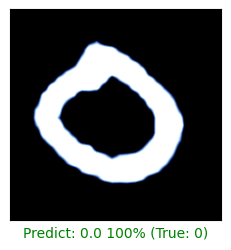

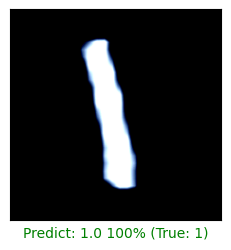

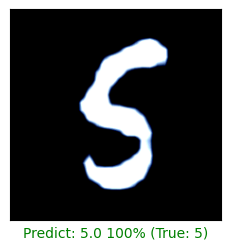

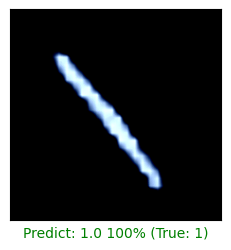

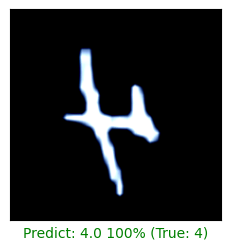

In [ ]:
test_loader = data_module.test_dataloader()
predictions_ = trainer1.predict(model1, test_loader)
all_max_indices = torch.tensor([])
all_prob = torch.tensor([])
for i in predictions_:
    all_max_indices = torch.concat([all_max_indices,i['y_pred']])
    all_prob = torch.concat([all_prob,i['y_prob']])

lst = np.random.randint(0, len(all_prob), 5)
print('Show images prediction')
for i in lst:
  plt.figure(figsize=(6,3))
  plt.subplot(1,2,1)
  plot_image(i, test_loader.dataset, all_max_indices, all_prob)
  plt.show()

CLASSIFICATION REPORT 
               precision    recall  f1-score   support

           0       1.00      0.99      0.99      1218
           1       0.99      0.99      0.99      1369
           2       0.98      0.98      0.98      1178
           3       0.99      0.99      0.99      1267
           4       0.98      0.99      0.98      1167
           5       0.98      0.97      0.98      1090
           6       0.98      0.99      0.99      1171
           7       0.97      1.00      0.98      1277
           8       1.00      0.97      0.98      1092
           9       0.98      0.97      0.98      1171

    accuracy                           0.98     12000
   macro avg       0.98      0.98      0.98     12000
weighted avg       0.98      0.98      0.98     12000

--------------------------------------------------
CONFUSION MATRIX 



<Axes: >

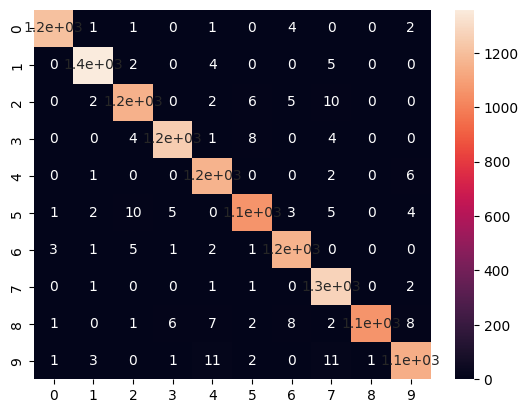

In [ ]:
y_true = np.array([data['labels'] for data in iter(test_loader.dataset)])
y_pred = all_max_indices

print('CLASSIFICATION REPORT \n',classification_report(y_true, y_pred))
print(f'-'*50)
cm = confusion_matrix(y_true, y_pred)
print('CONFUSION MATRIX \n')
sns.heatmap(cm, annot=True)

## 2. Training with variety of VGG: VGG-C, VGG-E and then compare all metrics in test set

VGG-C

In [ ]:
class VGG16_C(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG16_C, self).__init__()
        self.features = self._make_layers()
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _make_layers(self):
        layers = []
        in_channels = 3
        vgg_config = [64,        64, 'M',
                      128,      128, 'M',
                      256, 256, '256_c1', 'M',
                      512, 512, '512_c1', 'M',
                      512, 512, '512_c1', 'M']


        for v in vgg_config:
            if v == 'M':
                layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            else:
                if isinstance(v, str):
                    v = int(v.split('_')[0])
                    conv = nn.Conv2d(in_channels, v, kernel_size=1, padding=0, stride=1)
                else:
                    conv = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
                layers += [conv, nn.ReLU(inplace=True)]
                in_channels = v

        return nn.Sequential(*layers)


In [ ]:
# # Set paths
# val_path = '/kaggle/working/MNIST Dataset JPG format/MNIST - JPG - testing'
# train_path = "/kaggle/working/MNIST Dataset JPG format/MNIST - JPG - training"
# list_ = [name for name in os.listdir(train_path)]

# # Get data
# train_paths = get_path(train_path)
# val_paths = get_path(val_path)

# # Get data module
# data_module = DataModule(
#     batch_size=512, num_workers=4,
#     train_path = train_path, val_path = val_path)
# data_module.setup()
# train_loader = data_module.train_dataloader()
# val_loader = data_module.val_dataloader()

# Saving model params
model_checkpoint = ModelCheckpoint(
    dirpath = 'checkpoint/full_dataset',
    monitor = 'val_acc',
    verbose = True,
    mode = 'max',
    save_top_k = 1
)

# Early stopping callbacks
early_stopping = EarlyStopping(
    monitor = 'val_acc', mode = 'max',
    min_delta = 1e-4, patience = 5
)

callbacks = [model_checkpoint, early_stopping, ModelSummary(max_depth=1)]

model_build = VGG16_C
model2 = CustomVGG16(model = model_build)

trainer2 = L.Trainer(
    max_epochs = 2,
    detect_anomaly = True,
    devices="auto",
    callbacks = callbacks
)

trainer2.fit(model2, data_module)

INFO: Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:lightning.pytorch.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO: You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
INFO:lightning.pytorch.utilities.rank_zero:You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
IN

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 375: 'val_acc' reached 0.95210 (best 0.95210), saving model to '/content/checkpoint/full_dataset/epoch=0-step=375.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 375: 'val_acc' reached 0.95210 (best 0.95210), saving model to '/content/checkpoint/full_dataset/epoch=0-step=375.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 1, global step 750: 'val_acc' reached 0.98070 (best 0.98070), saving model to '/content/checkpoint/full_dataset/epoch=1-step=750-v2.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 750: 'val_acc' reached 0.98070 (best 0.98070), saving model to '/content/checkpoint/full_dataset/epoch=1-step=750-v2.ckpt' as top 1
INFO: `Trainer.fit` stopped: `max_epochs=2` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


In [ ]:
# Testing in training set
trainer2.test(model2, data_module)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9731666445732117     │
│         test_loss         │    0.0866350382566452     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.0866350382566452, 'test_acc': 0.9731666445732117}]

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Show images prediction


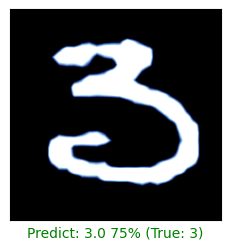

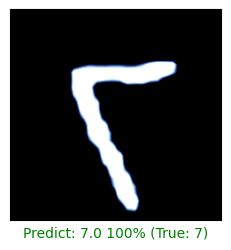

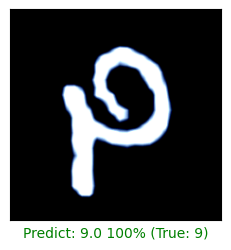

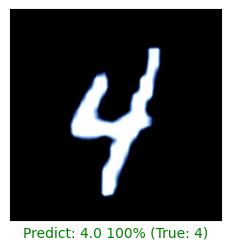

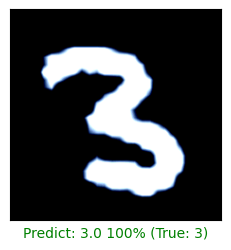

In [ ]:
test_loader = data_module.test_dataloader()
predictions_ = trainer2.predict(model2, test_loader)
all_max_indices = torch.tensor([])
all_prob = torch.tensor([])
for i in predictions_:
    all_max_indices = torch.concat([all_max_indices,i['y_pred']])
    all_prob = torch.concat([all_prob,i['y_prob']])

lst = np.random.randint(0, len(all_prob), 5)
print('Show images prediction')
for i in lst:
  plt.figure(figsize=(6,3))
  plt.subplot(1,2,1)
  plot_image(i, test_loader.dataset, all_max_indices, all_prob)
  plt.show()

CLASSIFICATION REPORT 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      1218
           1       0.99      0.99      0.99      1369
           2       0.97      0.96      0.97      1178
           3       0.99      0.98      0.98      1267
           4       0.99      0.96      0.98      1167
           5       0.96      0.98      0.97      1090
           6       0.98      0.99      0.99      1171
           7       0.99      0.98      0.98      1277
           8       0.96      0.98      0.97      1092
           9       0.96      0.97      0.97      1171

    accuracy                           0.98     12000
   macro avg       0.98      0.98      0.98     12000
weighted avg       0.98      0.98      0.98     12000

--------------------------------------------------
CONFUSION MATRIX 



<Axes: >

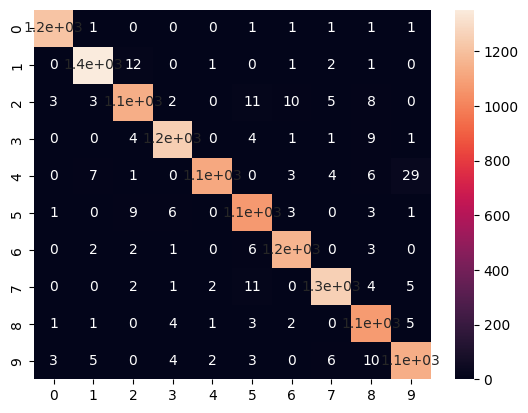

In [ ]:
y_true = np.array([data['labels'] for data in iter(test_loader.dataset)])
y_pred = all_max_indices

print('CLASSIFICATION REPORT \n',classification_report(y_true, y_pred))
print(f'-'*50)
cm = confusion_matrix(y_true, y_pred)
print('CONFUSION MATRIX \n')
sns.heatmap(cm, annot=True)

VGG-E original

In [ ]:
class VGG19(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG19_EConfig, self).__init__()
        self.features = self._make_layers()
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _make_layers(self):
        layers = []
        in_channels = 3
        vgg_config = [64, 64, 'M',
                      128, 128, 'M',
                      256, 256, 256, 256, 'M',
                      512, 512, 512, 512, 'M',
                      512, 512, 512, 512, 'M']


        for v in vgg_config:
            if v == 'M':
                layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            else:
                conv = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
                layers += [conv, nn.ReLU(inplace=True)]
                in_channels = v

        return nn.Sequential(*layers)

In [ ]:
# # Set paths
# val_path = '/content/MNIST Dataset JPG format/MNIST - JPG - testing'
# train_path = "/content/MNIST Dataset JPG format/MNIST - JPG - training"
# list_ = [name for name in os.listdir(train_path)]

# # Get data
# train_paths = get_path(train_path)
# val_paths = get_path(val_path)

# Get data module
data_module = DataModule(
    batch_size=128, num_workers=4,
    train_path = train_path, val_path = val_path)
data_module.setup()
train_loader = data_module.train_dataloader()
val_loader = data_module.val_dataloader()

# Saving model params
model_checkpoint = ModelCheckpoint(
    dirpath = 'checkpoint/full_dataset',
    monitor = 'val_acc',
    verbose = True,
    mode = 'max',
    save_top_k = 1
)

# Early stopping callbacks
early_stopping = EarlyStopping(
    monitor = 'val_acc', mode = 'max',
    min_delta = 1e-4, patience = 5
)

callbacks = [model_checkpoint, early_stopping, ModelSummary(max_depth=1)]

model_build = VGG19_E
model3 = CustomVGG16(model = model_build)

trainer3 = L.Trainer(
    max_epochs = 2,
    detect_anomaly = True,
    devices="auto",
    callbacks = callbacks
)

trainer3.fit(model3, data_module)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
INFO: Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:lightning.pytorch.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO: You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommende

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 375: 'val_acc' reached 0.87570 (best 0.87570), saving model to '/content/checkpoint/full_dataset/epoch=0-step=375.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 375: 'val_acc' reached 0.87570 (best 0.87570), saving model to '/content/checkpoint/full_dataset/epoch=0-step=375.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 1, global step 750: 'val_acc' reached 0.97640 (best 0.97640), saving model to '/content/checkpoint/full_dataset/epoch=1-step=750.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 750: 'val_acc' reached 0.97640 (best 0.97640), saving model to '/content/checkpoint/full_dataset/epoch=1-step=750.ckpt' as top 1
INFO: `Trainer.fit` stopped: `max_epochs=2` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


In [ ]:
# Testing in training set
trainer3.test(model3, data_module)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9727500081062317     │
│         test_loss         │    0.08705972135066986    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.08705972135066986, 'test_acc': 0.9727500081062317}]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Show images prediction


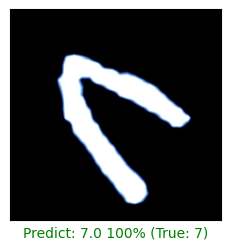

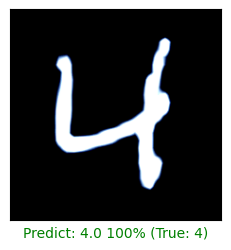

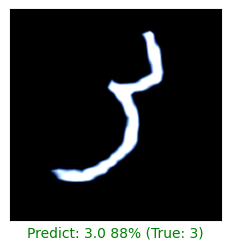

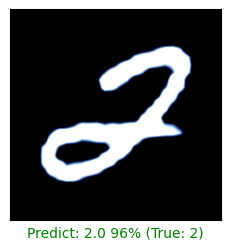

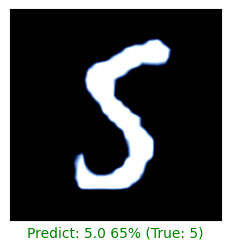

In [ ]:
test_loader = data_module.test_dataloader()
predictions_ = trainer_config.predict(model_config, test_loader)
all_max_indices = torch.tensor([])
all_prob = torch.tensor([])
for i in predictions_:
    all_max_indices = torch.concat([all_max_indices,i['y_pred']])
    all_prob = torch.concat([all_prob,i['y_prob']])

lst = np.random.randint(0, len(all_prob), 5)
print('Show images prediction')
for i in lst:
  plt.figure(figsize=(6,3))
  plt.subplot(1,2,1)
  plot_image(i, test_loader.dataset, all_max_indices, all_prob)
  plt.show()

CLASSIFICATION REPORT 
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      1175
           1       0.99      0.99      0.99      1326
           2       0.96      0.97      0.96      1203
           3       0.98      0.97      0.97      1212
           4       0.99      0.98      0.99      1185
           5       0.97      0.95      0.96      1108
           6       0.98      0.96      0.97      1218
           7       0.97      0.99      0.98      1303
           8       0.95      0.98      0.96      1095
           9       0.98      0.96      0.97      1175

    accuracy                           0.97     12000
   macro avg       0.97      0.97      0.97     12000
weighted avg       0.97      0.97      0.97     12000

--------------------------------------------------
CONFUSION MATRIX 



<Axes: >

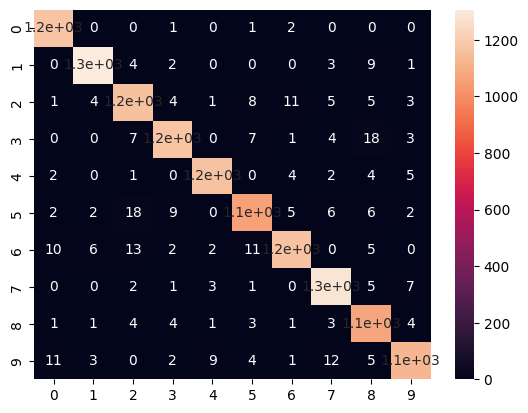

In [ ]:
y_true = np.array([data['labels'] for data in iter(test_loader.dataset)])
y_pred = all_max_indices

print('CLASSIFICATION REPORT \n',classification_report(y_true, y_pred))
print(f'-'*50)
cm = confusion_matrix(y_true, y_pred)
print('CONFUSION MATRIX \n')
sns.heatmap(cm, annot=True)

VGG-E config

In [ ]:
class VGG19_EConfig(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG19_EConfig, self).__init__()
        self.features = self._make_layers()
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _make_layers(self):
        layers = []
        in_channels = 3
        vgg_config = [64, 64, 'M',
                      128, 128, 'M',
                      256, 256, 256, '256_c1', 'M',
                      512, 512, 512, '512_c1', 'M',
                      512, 512, 512, '512_c1', 'M']


        for v in vgg_config:
            if v == 'M':
                layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            else:
                if isinstance(v, str):
                    v = int(v.split('_')[0])
                    conv = nn.Conv2d(in_channels, v, kernel_size=1, padding=0, stride=1)
                else:
                    conv = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
                layers += [conv, nn.ReLU(inplace=True)]
                in_channels = v

        return nn.Sequential(*layers)

In [ ]:
# # Set paths
# val_path = '/content/MNIST Dataset JPG format/MNIST - JPG - testing'
# train_path = "/content/MNIST Dataset JPG format/MNIST - JPG - training"
# list_ = [name for name in os.listdir(train_path)]

# # Get data
# train_paths = get_path(train_path)
# val_paths = get_path(val_path)

# Get data module
data_module = DataModule(
    batch_size=128, num_workers=4,
    train_path = train_path, val_path = val_path)
data_module.setup()
train_loader = data_module.train_dataloader()
val_loader = data_module.val_dataloader()

# Saving model params
model_checkpoint = ModelCheckpoint(
    dirpath = 'checkpoint/full_dataset',
    monitor = 'val_acc',
    verbose = True,
    mode = 'max',
    save_top_k = 1
)

# Early stopping callbacks
early_stopping = EarlyStopping(
    monitor = 'val_acc', mode = 'max',
    min_delta = 1e-4, patience = 5
)

callbacks = [model_checkpoint, early_stopping, ModelSummary(max_depth=1)]

model_build = VGG19_EConfig
model_config = CustomVGG16(model = model_build)

trainer_config = L.Trainer(
    max_epochs = 2,
    detect_anomaly = True,
    devices="auto",
    callbacks = callbacks
)

trainer_config.fit(model_config, data_module)

INFO: Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:lightning.pytorch.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO: You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
INFO:lightning.pytorch.utilities.rank_zero:You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
IN

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 375: 'val_acc' reached 0.95180 (best 0.95180), saving model to '/content/checkpoint/full_dataset/epoch=0-step=375.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 375: 'val_acc' reached 0.95180 (best 0.95180), saving model to '/content/checkpoint/full_dataset/epoch=0-step=375.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 1, global step 750: 'val_acc' reached 0.97490 (best 0.97490), saving model to '/content/checkpoint/full_dataset/epoch=1-step=750.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 750: 'val_acc' reached 0.97490 (best 0.97490), saving model to '/content/checkpoint/full_dataset/epoch=1-step=750.ckpt' as top 1
INFO: `Trainer.fit` stopped: `max_epochs=2` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


In [ ]:
# Testing in training set
trainer_config.test(model_config, data_module)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9742500185966492     │
│         test_loss         │    0.07960748672485352    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.07960748672485352, 'test_acc': 0.9742500185966492}]

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Show images prediction


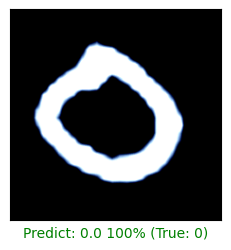

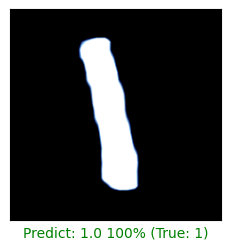

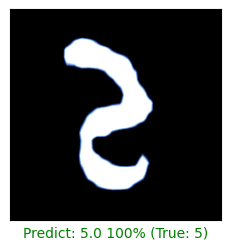

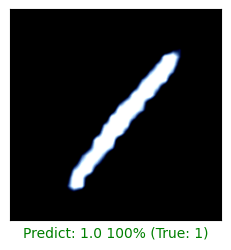

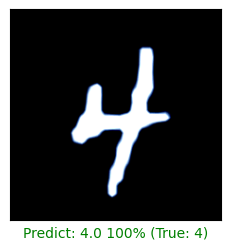

In [ ]:
test_loader = data_module.test_dataloader()
predictions_ = trainer_config.predict(model_config, test_loader)
all_max_indices = torch.tensor([])
all_prob = torch.tensor([])
for i in predictions_:
    all_max_indices = torch.concat([all_max_indices,i['y_pred']])
    all_prob = torch.concat([all_prob,i['y_prob']])

lst = np.random.randint(0, len(all_prob), 5)
print('Show images prediction')
for i in lst:
  plt.figure(figsize=(6,3))
  plt.subplot(1,2,1)
  plot_image(i, test_loader.dataset, all_max_indices, all_prob)
  plt.show()

CLASSIFICATION REPORT 
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      1218
           1       0.99      0.99      0.99      1369
           2       0.98      0.95      0.96      1178
           3       0.95      0.98      0.96      1267
           4       0.99      0.96      0.98      1167
           5       0.96      0.97      0.97      1090
           6       0.99      0.99      0.99      1171
           7       0.97      0.98      0.98      1277
           8       0.97      0.97      0.97      1092
           9       0.95      0.96      0.96      1171

    accuracy                           0.97     12000
   macro avg       0.97      0.97      0.97     12000
weighted avg       0.97      0.97      0.97     12000

--------------------------------------------------
CONFUSION MATRIX 



<Axes: >

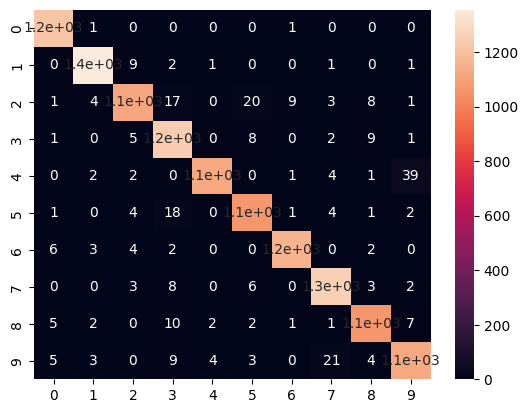

In [ ]:
y_true = np.array([data['labels'] for data in iter(test_loader.dataset)])
y_pred = all_max_indices

print('CLASSIFICATION REPORT \n',classification_report(y_true, y_pred))
print(f'-'*50)
cm = confusion_matrix(y_true, y_pred)
print('CONFUSION MATRIX \n')
sns.heatmap(cm, annot=True)

# Kết luận


| Model                       | Score   |
| ---                         | ---     |
| VGG16    40% data - 2 epoch | 0.9798  |
| VGG16   100% data - 2 epoch | 0.98408 |
| VGG16_C 100% data - 2 epoch | 0.9731  |
| VGG19_E 100% data - 2 epoch | 0.9742  |

* Nhận xét:
  * Model VGG16 100% cho kết quả tốt nhất nếu chiếu theo metrics accuracy
  * Mặc dù train ít data và size params ít hơn nhưng VGG 16 với 40% size data cho kết quả tốt hơn với VGG 19
  * Có thể do nguyên nhân train với batch size 128 nhỏ hơn 512 nên VGG cần train thêm epoch sẽ cải thiện hơn
  * Một số lỗi misclassify của từng model được liệt kê dưới đây:
    * Với model VGG16 40% size data: 2-5: 26 samples, 5-3: 15 samples, 2-6: 12 samples, 4-9: 21 samples

    * Với model VGG16 100% size data: 4-9: 11 samples, 9-7: 11 samples, 2-7: 10 samples
    * Với model VGG16_C:  1-2: 12 samples, 2-5: 11 samples, 2-6: 10 samples, 4-9: 29 samples, 9-8:10 samples
  * Với model VGG19: 4-9: 39 samples, 2-5: 20 samples, 9-7: 21 samples
  Trong đó cặp 4-9, 2-5 bị misclassify ở cả 4 model kể trên.